# Lab 07

In [86]:
import networkx as nx
import numpy as np
import random

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils.plotting import get_context_for_dark_IDE

import abc
from scipy.stats import chisquare

%matplotlib inline

SEED_SRC = 42
random.seed(SEED_SRC)
np.random.seed(SEED_SRC)

## P7.1[10%]

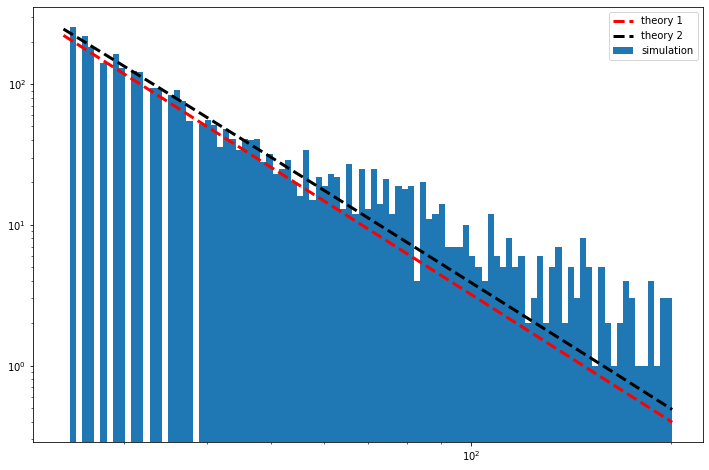

In [126]:
M = 4
FINAL_SIZE = 100_000
g = nx.generators.barabasi_albert_graph(FINAL_SIZE, M)

dgrs = dict(g.degree).values()
MIN, MAX = M, 10
num = 100
X = np.logspace(np.log(MIN), np.log(MAX), num)

with get_context_for_dark_IDE():
    fig, ax = plt.subplots(figsize=(12,8))
    hist, bins, _ = ax.hist(dgrs, bins=X, label='simulation')
    Y_theor_1 = [2*M*M / (k*k*k) *FINAL_SIZE for k in X]
    Y_theor_2 = [2*M*(M+1) / (k*(k+1)*(k+2)) *FINAL_SIZE for k in X]
    ax.plot(X, Y_theor_1, 'r--', label='theory 1', linewidth=3)
    ax.plot(X, Y_theor_2, 'k--', label='theory 2', linewidth=3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.legend()

## P7.3 [20%]
## P7.7 [10%]

In [144]:
class MaxClusterSimulation:
    def __init__(self, N, p_max, sim_num, p_inf_n__estim, p_size):
        self.N = N
        self.p_max = p_max
        self.sim_num = sim_num
        self.p_inf_n_estim = p_inf_n__estim
        self.p_size = p_size
        self.X = np.linspace(0, p_max*N, p_size)
        self.y = [0 for _ in range(p_size)]
        self.theor_y = [0 for _ in range(p_size)]


    def simulate(self):
        for _ in tqdm(range(self.sim_num)):
            for i, k in enumerate(self.X):
                p = k / self.N
                g = nx.generators.erdos_renyi_graph(self.N, p)
                self.y[i] += max([len(c) for c in nx.connected_components(g)]) / self.N / self.sim_num

        for i, k in enumerate(self.X):
            p_inf = self.calculate_p_inf(k)
            self.theor_y[i] = 0 if k < 1 else 1 - np.exp(-k * p_inf)

        plt.plot(self.X, self.y, 'b-', label='simulation')
        plt.plot(self.X, self.theor_y, 'r--', label='theory')
        plt.legend()
        plt.xlabel('<k>')
        plt.ylabel('Max cluster size / |V|')

    def calculate_p_inf(self, k):
            p_inf = 1
            for i in range(self.p_inf_n_estim):
                p_inf = 1 - np.exp(-k * p_inf)
            return p_inf

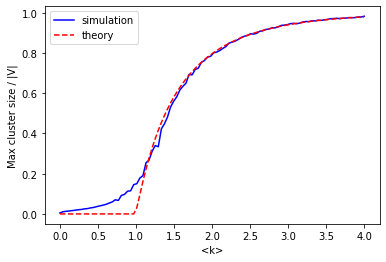

In [146]:
mcs = MaxClusterSimulation(200, 0.02, 100, 100, 100)

with get_context_for_dark_IDE():
    mcs.simulate()

## P7.10 [50%]

In [91]:
class FailureTester(abc.ABC):
    def __init__(self, params, graph_type):
        self.graph_type = graph_type
        self.params = params
        self.X = np.arange(self.params['steps'])
        self.y = [0 for _ in self.X]

    def simulate(self):
        for _ in tqdm(range(self.params['sim_num'])):
            g = self.generate_graph()
            for x in self.X:
                i = self.get_node(g)
                g.remove_node(i)
                self.y[x] += nx.number_connected_components(g) / self.params['sim_num']

    def generate_graph(self):
        if self.graph_type == 'ER':
            g = nx.generators.erdos_renyi_graph(self.params['N'], self.params['p'])
        elif self.graph_type == 'BA':
            g = nx.generators.barabasi_albert_graph(self.params['N'], self.params['M'])
        return g

    @staticmethod
    @abc.abstractmethod
    def get_node(g: nx.Graph):
        pass

    @staticmethod
    def add_axis_labels():
        plt.xlabel('Number of removed vertices')
        plt.ylabel('Avg number of connected components')

class RandomTester(FailureTester):
    def __init__(self, params, graph_type):
        super(RandomTester, self).__init__(params, graph_type)

    @staticmethod
    def get_node(g: nx.Graph):
        return np.random.choice(g.nodes)

    def plot(self):
        plt.plot(self.X, self.y, label=f'random {self.graph_type}')
        self.add_axis_labels()


class EagerTester(FailureTester):
    def __init__(self, params, graph_type):
        super(EagerTester, self).__init__(params, graph_type)

    @staticmethod
    def get_node(g: nx.Graph):
        return sorted(g.degree, key=lambda d_v: d_v[1], reverse=True)[0][0]

    def plot(self):
        plt.plot(self.X, self.y, label=f'Eager {self.graph_type}')
        self.add_axis_labels()


def analyze_simulations(simulators):
    with get_context_for_dark_IDE():
        for fs in simulators:
            fs.simulate()
            fs.plot()
        plt.legend()
        plt.show()

In [122]:

params = dict(
    N = 1_000,
    p = 0.01, # for ER
    M = 5,  # for BA
    steps = 200,
    sim_num = 100
)

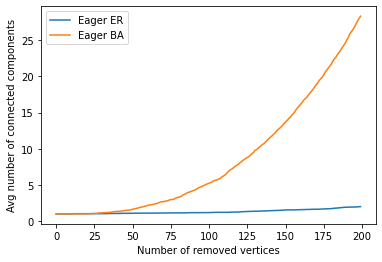

In [123]:
simulators = [
    EagerTester(params, 'ER'),
    EagerTester(params, 'BA'),
]

analyze_simulations(simulators)

In [124]:
simulators = [
    RandomTester(params, 'ER'),
    RandomTester(params, 'BA'),
]
analyze_simulations(simulators)

## P7.11 [10%]
- Grafy BA są bardziej podatne na celowe usuwanie wierzchołków niż grafy ER
- Grafy ER wykazują mniejszą odpornością na losowe usuwanie niż grafy BA